In [2]:
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('../examples/example_wp_log_peyton_manning.csv')
df['ds'] = pd.to_datetime(df['ds'])

In [3]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

### Modeling Custom Seasonality Functions
We have previously modeled the effect of nfl sundays using additional regressors. We could also view the NFL weeks as having a completly different weekly seasonality that offseason weeks, which means that we would like to have two different weekly seasonality curves. This can be modeled with customized seasonalites by providing a DataFrame containg rows for each week telling if it is a NFL week or an off-season week. This is provided to the periods_df input parameter when constructing the model. 

In [11]:
def get_week_type(date):
    if date.month > 8 or date.month < 2:
        return 'nfl_week'
    else:
        return 'offseason_week'
week_starts = pd.date_range(start=df['ds'].min(), end=df['ds'].max()+pd.DateOffset(days=366), freq=pd.DateOffset(days=7))
week_periods = pd.DataFrame({'ds_start': week_starts,
                             'ds_end': week_starts + pd.DateOffset(days=7),
                             'fourier_order': 3}) #Providing paramters here similarily to the holiday DataFrame

week_periods['period_name'] = week_periods['ds_start'].apply(get_week_type)
week_periods.head()

,ds_start,ds_end,fourier_order,period_name
0,2007-12-10,2007-12-17,3,nfl_week
1,2007-12-17,2007-12-24,3,nfl_week
2,2007-12-24,2007-12-31,3,nfl_week
3,2007-12-31,2008-01-07,3,nfl_week
4,2008-01-07,2008-01-14,3,nfl_week


In [12]:
m = Prophet(holidays=holidays, periods_df=week_periods, 
            weekly_seasonality=False)
m.fit(df)
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)

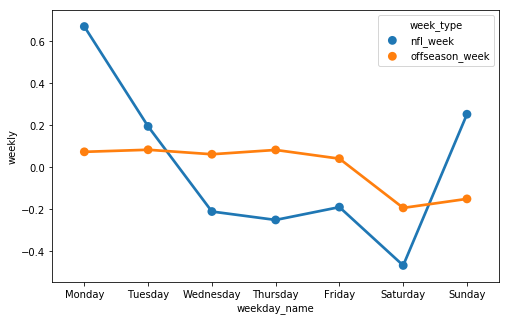

In [13]:
import seaborn as sns
from matplotlib.ticker import PercentFormatter
forecast['weekday_name'] = forecast['ds'].dt.weekday_name
plot_df = forecast.melt(id_vars='weekday_name', value_vars=['nfl_week', 'offseason_week'],
                        value_name='weekly', var_name='week_type')
plot_df = plot_df[plot_df.weekly != 0]
sns.pointplot(x='weekday_name', y='weekly', hue = 'week_type', data=plot_df)
plt.gcf().set_size_inches(8,5)

The custom period feature enables modeling of seasonality in a large variety of additional cases. For example to use different daily seasonality on weekends and weekdays for subdaily data. Addtionaly, it lets use use exact days in month and year rather than approximating it as 30.5 and 365.25

The concept of a period DataFrame can in future be further extended to allow Half Fourier Series, for when the underlying seasonality is discontinuous, for example between a restaurant closing and opening. Additionally period breaks could be added, to for example avoid applying seasonality when there's also an holiday on that day. 
